In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:

import pandas as pd                                     # Data analysis tool
import numpy as np                                      # Package for scientific computing
from sklearn.model_selection import train_test_split    # Splits arrays or matrices into random train and test subsets
from sklearn.model_selection import KFold               # Cross-validator
from sklearn.model_selection import cross_validate      # Evaluate metrics by cross-validation
from sklearn.model_selection import GridSearchCV        # Search over specified parameter values for an estimator
from sklearn.compose import ColumnTransformer           # Applies transformers to columns of DataFrames
from sklearn.pipeline import Pipeline                   # Helps building a chain of transforms and estimators
from sklearn.impute import SimpleImputer                # Imputation transformer for completing missing values
from sklearn.preprocessing import OneHotEncoder         # Encode categorical features
from sklearn.metrics import mean_absolute_error, mean_squared_error         # One of many statistical measures of error
from xgboost import XGBRegressor

In [3]:
training_set = pd.read_csv('../input/titanic/train.csv')
test_set = pd.read_csv('../input/titanic/test.csv')

In [4]:
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
X_train = training_set.copy()
y_train = X_train.Survived
X_train.drop(['Survived'], axis = 1, inplace = True)

In [6]:
X_test = test_set.copy()

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(891, 11)
(891,)
(418, 11)


In [8]:
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_train, y_train, 
                                                                train_size=0.8, 
                                                                test_size=0.2, 
                                                                random_state=0)

In [9]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Pclass       891 non-null    int64  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [10]:
missing_values = X_train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print(missing_values)

Cabin       687
Age         177
Embarked      2
dtype: int64


In [11]:
# Select categorical columns with no more than 15 unique values
categorical_cols = [col for col in X_train_full.columns if 
                   X_train_full[col].nunique() <= 15 and
                   X_train_full[col].dtype == 'object']

# Select numeric values
numeric_cols = [col for col in X_train_full.columns if
                X_train_full[col].dtype in ['int64', 'float64']]

# Keep selected columns
my_columns = categorical_cols + numeric_cols
X_train = X_train_full[my_columns].copy()
X_valid = X_valid_full[my_columns].copy()
X_test = X_test[my_columns].copy()

In [12]:
numerical_transformer = SimpleImputer(strategy='mean')
categorical_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers = [
    ('num', numerical_transformer, numeric_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [13]:
MSEs = {}

In [14]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter = 500, solver='liblinear', random_state = 0)

my_pipeline_LR = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

my_pipeline_LR.fit(X_train, y_train)
preds = my_pipeline_LR.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['Logistic Regression'] = MSE
print('MSE:', MSE)

MSE: 0.2011173184357542


In [15]:
kfold = KFold(shuffle=True, random_state=0)
scores = cross_validate(my_pipeline_LR, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)

print('Average MSE score:', (scores['test_score'] * -1).mean())

Average MSE score: 0.19372599231754162


In [16]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(verbosity = 0, random_state = 0)

my_pipeline_xgb = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_xgb)])

my_pipeline_xgb.fit(X_train, y_train)
preds = my_pipeline_xgb.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['XGBoost'] = MSE
print('MSE:', MSE)

MSE: 0.16201117318435754


In [17]:
from sklearn.neighbors import KNeighborsClassifier
model_knn = KNeighborsClassifier(n_neighbors=3)

my_pipeline_knn = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_knn)])

my_pipeline_knn.fit(X_train, y_train)
preds = my_pipeline_knn.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['KNN'] = MSE
print('MSE:', MSE)

MSE: 0.31843575418994413


In [18]:
from sklearn.svm import SVC
model_svc = SVC(gamma='auto')

my_pipeline_svc = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_svc)])

my_pipeline_svc.fit(X_train, y_train)
preds = my_pipeline_svc.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['SVM'] = MSE
print('MSE:', MSE)

MSE: 0.39664804469273746


In [19]:
from sklearn.naive_bayes import GaussianNB
model_nb = GaussianNB()

my_pipeline_nb = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_nb)])

my_pipeline_nb.fit(X_train, y_train)
preds = my_pipeline_nb.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['Naive Bayes'] = MSE
print('MSE:', MSE)

MSE: 0.2122905027932961


In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
model_lda = LinearDiscriminantAnalysis()

my_pipeline_lda = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_lda)])

my_pipeline_lda.fit(X_train, y_train)
preds = my_pipeline_lda.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['LDA'] = MSE
print('MSE:', MSE)

MSE: 0.20670391061452514


In [21]:
from sklearn.ensemble import BaggingClassifier
model_bagging = BaggingClassifier(n_jobs = -1, random_state = 0)

my_pipeline_bagging = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_bagging)])

my_pipeline_bagging.fit(X_train, y_train)
preds = my_pipeline_bagging.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['Bagging'] = MSE
print('MSE:', MSE)

MSE: 0.18994413407821228


In [22]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(random_state=0, n_jobs = -1)

my_pipeline_rf = Pipeline(steps=[('preprocessor', preprocessor), ('model', model_rf)])

my_pipeline_rf.fit(X_train, y_train)
preds = my_pipeline_rf.predict(X_valid)
MSE = mean_squared_error(y_valid, preds)
MSEs['Random Forest'] = MSE
print('MSE:', MSE)

MSE: 0.1452513966480447


In [23]:
import matplotlib.pyplot as plt

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

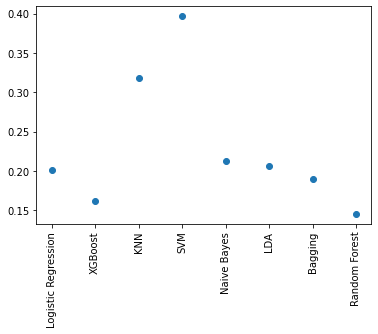

In [24]:
plt.scatter(MSEs.keys(), MSEs.values())
plt.xticks(rotation=90)

As we can see, here Random Forest performs better than the other methods with (mostly) default parameters. We could try getting better parameters for the other algorithms using grid search, but they likely won't be better than RF. 

In [25]:
final_model = model_rf
final_pipeline = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', final_model)
])

X_train = training_set.copy()
y_train = X_train.Survived

final_pipeline.fit(X_train, y_train)

final_prediction = final_pipeline.predict(X_test)

In [26]:
output = pd.DataFrame({
    'PassengerId': X_test.PassengerId,
    'Survived': final_prediction
})
output.to_csv('submission.csv', index = False)

In [27]:
final_prediction.shape

(418,)